In [1]:
import tensorflow as tf

from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.platform import gfile

import tensorflow_model_optimization as tfmot

from tensorflow_model_optimization.python.core.quantization.keras.experimental.default_n_bit.default_n_bit_quantize_configs import (
    NoOpQuantizeConfig,
)
from tensorflow_model_optimization.python.core.quantization.keras.experimental.default_n_bit.default_n_bit_quantize_registry import (
    DefaultNBitConvQuantizeConfig,
    DefaultNBitQuantizeConfig,
)
from tensorflow_model_optimization.python.core.quantization.keras.experimental.default_n_bit.default_n_bit_quantize_scheme import (
    DefaultNBitQuantizeScheme,
)

import functools

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, pickle
import shutil
import json
from scipy.io import  wavfile
from IPython import display

import str_ww_util as util
import get_dataset
import keras_model as models

from IPython import display

In [2]:
rng = np.random.default_rng(2024)

In [3]:
from get_dataset import decode_audio, get_label, get_waveform_and_label, \
                        convert_labels_str2int, convert_to_int16, cast_and_pad, \
                        convert_dataset, get_preprocess_audio_func, prepare_background_data, \
                        get_training_data, count_labels, is_batched

In [4]:
Flags, unparsed = util.parse_command()

In [5]:
## Set these for an extra short test just to validate that the code runs
# Flags.num_train_samples = 100
# Flags.num_val_samples = 100
# Flags.num_test_samples = 100

load_pretrained_model = False # True to load from a file, False to build/train from scratch
save_model = False

# 'trained_models/str_ww_model.h5' is the default save path for train.py
pretrained_model_path = 'trained_models/str_ww_model.h5' # path to load from if load_pretrained_model is True

Flags.epochs = 2

In [6]:
Flags.background_volume=1.0 # experimenting
Flags.use_qat = True

In [7]:
try:
    with open('streaming_config.json', 'r') as fpi:
        streaming_config = json.load(fpi)
    Flags.data_dir = streaming_config['speech_commands_path']
except:
    raise RuntimeError("""
        In this directory, copy streaming_config_template.json to streaming_config.json
        and edit it to point to the directories where you have the speech commands dataset
        and (optionally) the MUSAN noise data set.
        """)
Flags.bg_path = Flags.data_dir

In [8]:
# ds_train, ds_test, ds_val = get_training_data(Flags)

label_count=3
background_frequency = Flags.background_frequency
background_volume_range_= Flags.background_volume
model_settings = models.prepare_model_settings(label_count, Flags)

In [9]:
import importlib
importlib.reload(get_dataset)

<module 'get_dataset' from '/Users/jeremy/dev/tiny_mlperf/tiny_main/benchmark/training/streaming_wakeword/get_dataset.py'>

In [10]:
ds_train, ds_test, ds_val = get_dataset.get_training_data(Flags)


Metal device set to: Apple M1


2024-02-17 07:33:00.333351: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-17 07:33:00.334032: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-02-17 07:33:01.099615: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [11]:
for dat in ds_train.unbatch().take(1):
  print("One element from the training set has shape:")
  print(f"Input tensor shape: {dat[0].shape}")
  print(f"Label shape: {dat[1].shape}")
  print(f"Label : {dat[1]}")
  break


One element from the training set has shape:
Input tensor shape: (49, 1, 40)
Label shape: (3,)
Label : [0. 0. 1.]


In [12]:
## probably don't need to shuffle val and test sets
train_shuffle_buffer_size = 85511
ds_train = ds_train.shuffle(train_shuffle_buffer_size)

These next three cells can be quite slow in the current implementation, so uncomment if you want to see them.
They
1. Create a dataset with only targets if you want to examine those.
2. Show spectra of some target words
3. Count the distribution of classes in the training set

In [13]:
# create a tmp dataset with only the target words
# ds_only_target = ds_train.filter(lambda dat: dat['label'] == 0)
# print("Five elements from the only-target set:")
# for dat in ds_only_target.take(5):
#   print(f"Input tensor shape: {dat['audio'].shape}")  
#   print(f"Label = {dat['label']}; shape = {dat['label'].shape}")


In [14]:
# max_target_examples = 3
# target_count = 0
# target = tf.constant(0)
# plt.Figure(figsize=(10,4))
# for dat in ds_train.unbatch():
#   # label_string = dat[1].numpy().decode('utf8')
#   if dat[1] == target:
#     target_count += 1
#     ax = plt.subplot(max_target_examples, 1, target_count)
#     # display.display(display.Audio(dat[0].numpy(), rate=16000))

#     log_spec = dat[0].numpy()
#     height = log_spec.shape[0]
#     width = log_spec.shape[1]
#     X = np.linspace(0, 1.0, num=width, dtype=float)
#     Y = range(height)
#     ax.pcolormesh(X, Y, np.squeeze(log_spec))
#     if target_count >= max_target_examples:
#       break
# plt.tight_layout()

In [15]:
## look at the label breakdown in the training set
# print(count_labels(ds_train))

## current count_labels is very slow.  some scratch code here towards
## implementing a faster one by converting labels to one-hot and then summing.
# tf.one_hot(indices, depth)
# ds_1hot = ds_train.map(lambda dat: tf.one_hot(dat[1], 3))
# xx = iter(ds_1hot).next()


## Build and Train Model

In [16]:
# during development, to reload the models module w/o restarting the kernel
# import importlib
# importlib.reload(models)

In [17]:
if load_pretrained_model:
  print(f"Loading pretrained model from {pretrained_model_path}")
  with tfmot.quantization.keras.quantize_scope(): # needed for the QAT wrappers
    model = keras.models.load_model(pretrained_model_path)
else:
  print(f"Building model from scratch")
  model = models.get_model(args=Flags, use_qat=Flags.use_qat) # compile step is done inside get_model()

Building model from scratch
DS TCN model for streaming invoked
Input shape = [49, 1, 40]
Apple Silicon platform detected. Using legacy adam as standard Keras Adam is slow on this processor.


In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 49, 1, 40)]       0         
                                                                 
 quantize_layer (QuantizeLay  (None, 49, 1, 40)        3         
 er)                                                             
                                                                 
 quant_depthwise_conv2d (Qua  (None, 45, 1, 40)        205       
 ntizeWrapperV2)                                                 
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 45, 1, 128)       5377      
 erV2)                                                           
                                                                 
 quant_batch_normalization (  (None, 45, 1, 128)       513       
 QuantizeWrapperV2)                                          

In [19]:
if not load_pretrained_model:
  callbacks = util.get_callbacks(args=Flags)
  train_hist = model.fit(ds_train, validation_data=ds_val, callbacks=callbacks,
                         epochs=Flags.epochs)

Epoch 1/2


2024-02-17 07:33:07.639272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-17 07:33:17.765861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 487 of 85511
2024-02-17 07:33:27.769382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 855 of 85511
2024-02-17 07:33:37.975744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 880 of 85511
2024-02-17 07:33:47.783031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 905 of 85511
2024-02-17 07:33:57.795786: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 929 of 85511
2024-02-17 07:34:07.950412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling u

   1154/Unknown - 172s 58ms/step - loss: 0.6932 - categorical_accuracy: 0.7280 - precision: 0.1942 - recall: 0.0906

2024-02-17 07:35:59.357602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1154/1154 [==============================] - 192s 76ms/step - loss: 0.6932 - categorical_accuracy: 0.7280 - precision: 0.1942 - recall: 0.0906 - val_loss: 1.1685 - val_categorical_accuracy: 0.2483 - val_precision: 0.2581 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/2


2024-02-17 07:36:29.010944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 489 of 85511
2024-02-17 07:36:39.341962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 855 of 85511
2024-02-17 07:36:49.283812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 878 of 85511
2024-02-17 07:36:59.249160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 901 of 85511
2024-02-17 07:37:09.273037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 924 of 85511
2024-02-17 07:37:19.012893: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 946 of 85511
2024-02-17 07:37:29.277917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shu

1154/1154 [==============================] - 448s 89ms/step - loss: 0.2397 - categorical_accuracy: 0.9373 - precision: 0.2139 - recall: 0.7368 - val_loss: 1.7614 - val_categorical_accuracy: 0.2961 - val_precision: 0.2479 - val_recall: 1.0000 - lr: 0.0010


In [20]:
if save_model:
  model.save('trained_models/str_ww_model_nb.h5')

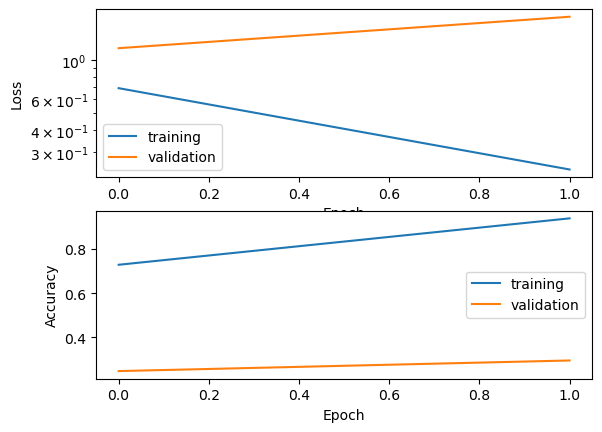

In [21]:
if not load_pretrained_model:
  plt.subplot(2,1,1)
  plt.semilogy(train_hist.epoch, train_hist.history['loss'], train_hist.history['val_loss'])
  plt.legend(['training', 'validation'])
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.subplot(2,1,2)
  plt.plot(train_hist.epoch, train_hist.history['categorical_accuracy'], train_hist.history['val_categorical_accuracy'])
  plt.legend(['training', 'validation'])
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')


In [22]:
## This cell can be slow with QAT enabled
print(f"Eval on training set")
model.evaluate(ds_train)
print(f"Eval on validation set")
model.evaluate(ds_val)
print(f"Eval on test set")
model.evaluate(ds_test)

Eval on training set


2024-02-17 07:43:57.515244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 473 of 85511
2024-02-17 07:44:07.699359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 854 of 85511
2024-02-17 07:44:17.768801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 877 of 85511
2024-02-17 07:44:27.683342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 901 of 85511
2024-02-17 07:44:37.549638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 924 of 85511
2024-02-17 07:44:47.531135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 947 of 85511
2024-02-17 07:44:57.563484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shu

      6/Unknown - 108s 27ms/step - loss: 0.8987 - categorical_accuracy: 0.5133 - precision: 0.1879 - recall: 1.0000

2024-02-17 07:45:34.965574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1154/1154 [==============================] - 136s 24ms/step - loss: 0.9539 - categorical_accuracy: 0.4656 - precision: 0.2036 - recall: 1.0000
Eval on validation set
147/147 [==============================] - 22s 150ms/step - loss: 1.7614 - categorical_accuracy: 0.2961 - precision: 0.2479 - recall: 1.0000
Eval on test set
111/111 [==============================] - 4s 38ms/step - loss: 2.4373 - categorical_accuracy: 0.0316 - precision: 0.0177 - recall: 1.0000


[2.4373128414154053, 0.031621988862752914, 0.017719218507409096, 1.0]

In [23]:
label_list = ['marvin', 'silent', 'other']
model_out = model.predict(ds_val)
model_out = np.squeeze(model_out)
y_pred_val = np.argmax(model_out, axis=1)

y_true_val = np.nan*np.zeros(y_pred_val.shape[0])
for i,dat in enumerate(ds_val.unbatch()):
  y_true_val[i] = np.argmax(dat[1])

acc = sum(y_pred_val == y_true_val) / len(y_true_val)
print(f'Validation set accuracy: {acc:.1%}')

      1/Unknown - 0s 405ms/step

2024-02-17 07:46:30.014402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


147/147 [==============================] - 19s 129ms/step
Validation set accuracy: 29.6%


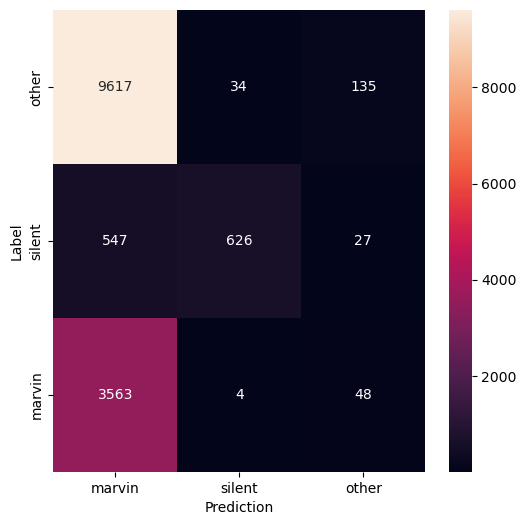

In [24]:
confusion_mtx = tf.math.confusion_matrix(y_true_val, y_pred_val) 
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Post-Training Quantization

In [25]:
num_calibration_steps = 5
tfl_file_name = "strm_ww_int8.tflite"

# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
if True: 
  # If we omit this block, we'll get a floating-point TFLite model,
  # with this block, the weights and activations should be quantized to 8b integers, 
  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  ds_calibration = ds_val.unbatch().batch(1).take(num_calibration_steps)
  def representative_dataset_gen():
    for next_spec, label in ds_calibration:
      yield [next_spec] 
    
  converter.representative_dataset = representative_dataset_gen
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8] # use this one
  # converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

  converter.inference_input_type = tf.int8  # or tf.uint8; should match dat_q in eval_quantized_model.py
  converter.inference_output_type = tf.int8  # or tf.uint8

tflite_quant_model = converter.convert()

with open(tfl_file_name, "wb") as fpo:
  fpo.write(tflite_quant_model)
print(f"Wrote to {tfl_file_name}")
!ls -l $tfl_file_name

INFO:tensorflow:Assets written to: /var/folders/qb/jcjkm0nx4878vyqfjy786xdh0000gn/T/tmp1pn89iqd/assets


INFO:tensorflow:Assets written to: /var/folders/qb/jcjkm0nx4878vyqfjy786xdh0000gn/T/tmp1pn89iqd/assets
/Users/jeremy/miniforge3/envs/syn_dev/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2024-02-17 07:47:10.948425: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-02-17 07:47:10.948449: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-02-17 07:47:10.949026: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/qb/jcjkm0nx4878vyqfjy786xdh0000gn/T/tmp1pn89iqd
2024-02-17 07:47:10.954933: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-02-17 07:47:10.954942: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug i

Wrote to strm_ww_int8.tflite
-rw-r--r--  1 jeremy  staff  64520 Feb 17 07:47 strm_ww_int8.tflite


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


#### Test Quantized Interpreter on One Spectrogram

In [26]:
interpreter = tf.lite.Interpreter(model_path=tfl_file_name)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
output_data = []
labels = []
input_scale, input_zero_point = input_details[0]["quantization"]

In [27]:
spec, label = next(ds_val.unbatch().batch(1).take(1).as_numpy_iterator())

spec_q = np.array(spec/input_scale + input_zero_point, dtype=np.int8)
print(f"min = {np.min(spec_q)}, max = {np.max(spec_q)}")

interpreter.set_tensor(input_details[0]['index'], spec_q)
interpreter.invoke()
out_vec = interpreter.get_tensor(output_details[0]['index'])
print(out_vec)
pred_label = np.argmax(out_vec[0])
print(f"True label = {label}. Output = {out_vec}.  Predicted label = {pred_label}")

min = -128, max = 76
[[-19 -89 -47]]
True label = [[0. 0. 1.]]. Output = [[-19 -89 -47]].  Predicted label = 0


#### Now Measure Quantized Accuracy on Validation Set

In [28]:
predictions = []
labels = []
# num_test_samples = 100

eval_ds = ds_val # ds_val OR ds_train OR ds_test

for next_spec, next_label in eval_ds.unbatch().batch(1): # .take(num_test_samples):    
  spec_q = np.array(next_spec/input_scale + input_zero_point, dtype=np.int8)
  
  interpreter.set_tensor(input_details[0]['index'], spec_q)
  interpreter.invoke()
  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  predictions.append(np.argmax(interpreter.get_tensor(output_details[0]['index'])))
  labels.append(next_label[0])

predictions = np.array(predictions)
labels = np.argmax(np.array(labels), axis=1)
num_correct = np.sum(labels == predictions)
acc = num_correct / len(labels)
print(f"Accuracy = {acc:5.3f} ({num_correct}/{len(labels)})")


Accuracy = 0.297 (4343/14601)


As of 10 Feb 2024, the quantized accuracy on the training set is 83% and 83% on the validation set.

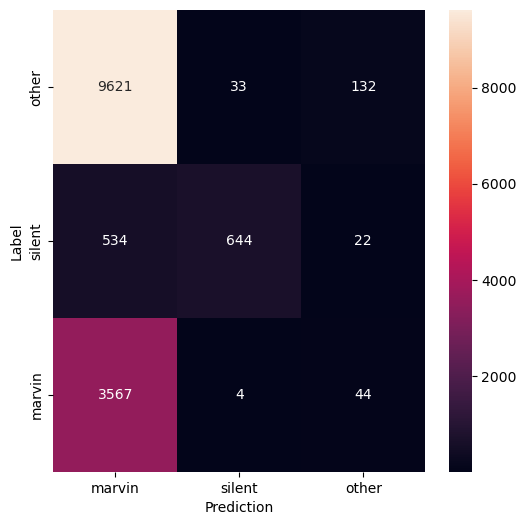

In [29]:
  
confusion_mtx = tf.math.confusion_matrix(labels, predictions) 
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run Model on Long Waveform

In [30]:
if streaming_config['musan_path'] is None or len(streaming_config['musan_path']) == 0:
  raise RuntimeError("Stopping before the long-wave test, which requires the musan dataset in streaming_config['musan_path']")

In [31]:
def trim_and_normalize(wav_in, rel_thresh):
  """
  Trims leading and trailing 'quiet' segments, where quiet is defined as 
  less than rel_thresh*max(wav_in).
  Then scales such that RMS of trimmed wav = 1.0
  """
  idx_start = np.min(np.nonzero(ww_wav > np.max(ww_wav)*rel_thresh))
  idx_stop  = np.max(np.nonzero(ww_wav > np.max(ww_wav)*rel_thresh))
  
  wav_out = wav_in[idx_start:idx_stop]
  wav_out = wav_out / np.std(wav_out) 
  return wav_out

In [32]:

Flags.variable_length=True
model_tv = models.get_model(args=Flags, use_qat=Flags.use_qat)
Flags.variable_length=False
# transfer weights from trained model into variable-length model
model_tv.set_weights(model.get_weights())

DS TCN model for streaming invoked
Input shape = [None, 1, 40]
Apple Silicon platform detected. Using legacy adam as standard Keras Adam is slow on this processor.


In [33]:
rel_thresh = 0.05 # trim out leading/trailing space with less than rel_thresh*max(waveform)

model_settings = models.prepare_model_settings(label_count, Flags)
samp_freq = model_settings['sample_rate']

background_wav_file = os.path.join(streaming_config['musan_path'], 
                                   'noise/free-sound/noise-free-sound-0048.wav'
                                  )


ww_files = ['marvin/cce7416f_nohash_0.wav',
            'marvin/321aba74_nohash_0.wav',
            'marvin/fcb25a78_nohash_0.wav'
           ]

insertion_secs = [1.5, 3.5, 5.0]
# snr_levels = [2.0, 1.0, 0.5]
snr_levels = [20.0, 5.0, 1.0]

for i in range(len(ww_files)):
  ww_files[i] = os.path.join(Flags.data_dir, ww_files[i])


In [34]:
bg_sampling_freq, long_wav = wavfile.read(background_wav_file)
assert bg_sampling_freq == samp_freq
long_wav = long_wav / np.std(long_wav) # normalize to RMS = 1.0

long_wav = long_wav[0:10*samp_freq]

# long_wav = long_wav * 0.0 # uncomment to zero out background noise

ww_present = np.nan*np.zeros(long_wav.shape)

for i in range(len(ww_files)):
  ww_sampling_freq, ww_wav = wavfile.read(ww_files[i])
  assert int(ww_sampling_freq) == samp_freq
  index = int(insertion_secs[i] * samp_freq)
  
  ww_wav = trim_and_normalize(ww_wav, rel_thresh)
  assert index+len(ww_wav) < len(long_wav)
  
  long_wav[index:index+len(ww_wav)] += snr_levels[i]*ww_wav
  ww_present[index:index+len(ww_wav)] = 1

model_settings_long = model_settings.copy() #.update({'desired_samples':len(long_wav)})
model_settings_long.update({'desired_samples':len(long_wav)})

long_wav = long_wav / np.max(np.abs(long_wav)) # scale into [-1.0, +1.0] range
feature_extractor_long = get_preprocess_audio_func(model_settings_long, is_training=False)
long_spec = feature_extractor_long({'audio':long_wav})['audio'].numpy()

print(f"Long waveform shape = {long_wav.shape}, spectrogram shape = {long_spec.shape}")


Long waveform shape = (160000,), spectrogram shape = (499, 1, 40)


In [44]:
## scale wav into [-32768, +32767] and cast to int16 for wav file
wavfile.write('long_wav.wav', 16000, (long_wav*(2**15)).astype(np.int16))

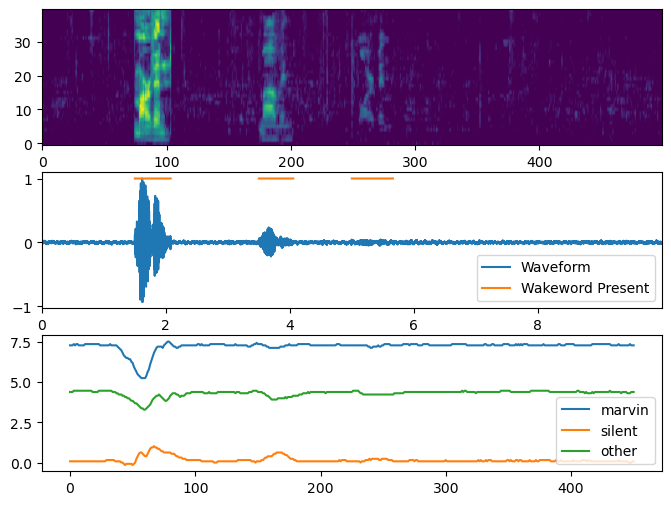

In [45]:
plt.figure(figsize=(8, 6))
plt.subplot(3,1,1)
plt.imshow(np.squeeze(long_spec).T, origin="lower", aspect='auto')

plt.subplot(3,1,2)
t = np.arange(len(long_wav))/samp_freq
plt.plot(t, long_wav, t, ww_present)
plt.xlim([np.min(t), np.max(t)])
plt.legend(['Waveform', 'Wakeword Present'], loc='lower right')

plt.subplot(3,1,3)
yy = model_tv(np.expand_dims(long_spec, 0))[0].numpy()
# plt.plot(yy)
plt.plot(yy[:])
plt.legend(label_list, loc='lower right')
display.display(display.Audio(long_wav, rate=16000))

In [ ]:
raise RuntimeError("Not an error -- just stop here")

## Scratch Space
